In [1]:
from my_metrics import *
from sub_network import *
from data_loader import *
from plotting_utils import *

import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

import pickle

import matplotlib.pyplot as plt

In [2]:
image_dir1 = r"D:\ib811_database\S1_IEEE"
image_dir2 = r"D:\ib811_database\S2_IEEE"

images1 = load_images(image_dir1)
images2 = load_images(image_dir2)

# pairs, labels = create_labels(images1, images2)
pairs_1, pairs_2, labels = create_labels(images1, images2)

In [3]:
# train_pairs, test_pairs, train_labels, test_labels = train_test_split(pairs, labels, test_size=0.2, random_state=42)
# print("train_pairs.shape={}".format(train_pairs.shape))
# print("test_pairs.shape={}".format(test_pairs.shape))
# print("train_labels.shape={}".format(train_labels.shape))
# print("test_labels.shape={}".format(test_labels.shape))
train_pairs_1, test_pairs_1, train_pairs_2, test_pairs_2, train_labels, test_labels = train_test_split(
    pairs_1, pairs_2, labels, test_size=0.2, random_state=42
)

print("train_pairs_1.shape={}".format(train_pairs_1.shape))
print("test_pairs_1.shape={}".format(test_pairs_1.shape))
print("train_labels.shape={}".format(train_labels.shape))
print("test_labels.shape={}".format(test_labels.shape))

# trainPairs_0 = np.array([pair[0] for pair in train_pairs]).reshape(-1, 256, 256, 1)
# trainPairs_1 = np.array([pair[1] for pair in train_pairs]).reshape(-1, 256, 256, 1)
# testPairs_0 = np.array([pair[0] for pair in test_pairs]).reshape(-1, 256, 256, 1)
# testPairs_1 = np.array([pair[1] for pair in test_pairs]).reshape(-1, 256, 256, 1)
trainPairs_0 = np.array(train_pairs_1).reshape(-1, 256, 256, 1)
trainPairs_1 = np.array(train_pairs_2).reshape(-1, 256, 256, 1)
testPairs_0 = np.array(test_pairs_1).reshape(-1, 256, 256, 1)
testPairs_1 = np.array(test_pairs_2).reshape(-1, 256, 256, 1)

train_pairs_1.shape=(512, 256, 256)
test_pairs_1.shape=(128, 256, 256)
train_labels.shape=(512,)
test_labels.shape=(128,)


In [4]:
#主網路架構

inputShape = (256, 256, 1)

inputA = Input(inputShape)
inputB = Input(inputShape)

featureExtractor = sub_network(inputShape)

featsA = featureExtractor(inputA)
featsB = featureExtractor(inputB)

distance = EuclideanDistance()([featsA, featsB])

outputs = Dense(1, activation="sigmoid")(distance)

model = Model(inputs=[inputA, inputB], outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496 

In [5]:
model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy", precision, recall, f1_score]) 

model_checkpoint = ModelCheckpoint("snn.hdf5", monitor="val_loss", verbose=1, save_best_only=True)

# history = model.fit(
#     [trainPairs_0, trainPairs_1], train_labels,
#     validation_data=([testPairs_0, testPairs_1], test_labels),
#     batch_size=16, 
#     epochs=100,
#     callbacks=[model_checkpoint])
history = model.fit(
    [trainPairs_0, trainPairs_1], train_labels,
    validation_data=([testPairs_0, testPairs_1], test_labels),
    batch_size=16,
    epochs=100,
    callbacks=[model_checkpoint]
)

with open("trainHistory.txt", "wb") as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.5156 - precision: 0.5156 - recall: 1.0000 - f1_score: 0.6722
Epoch 1: val_loss improved from inf to 0.12507, saving model to snn.hdf5
32/32 [==============================] - 8s 132ms/step - loss: 0.1206 - accuracy: 0.5156 - precision: 0.5156 - recall: 1.0000 - f1_score: 0.6722 - val_loss: 0.1251 - val_accuracy: 0.4375 - val_precision: 0.4375 - val_recall: 1.0000 - val_f1_score: 0.5905
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.5156 - precision: 0.5156 - recall: 1.0000 - f1_score: 0.6718
Epoch 2: val_loss improved from 0.12507 to 0.11849, saving model to snn.hdf5
32/32 [==============================] - 4s 121ms/step - loss: 0.1129 - accuracy: 0.5156 - precision: 0.5156 - recall: 1.0000 - f1_score: 0.6718 - val_loss: 0.1185 - val_accuracy: 0.5156 - val_precision: 0.4760 - val_recall: 1.0000 - val_f1_score: 0.6276
Epoch 3/100
32/32 [===================

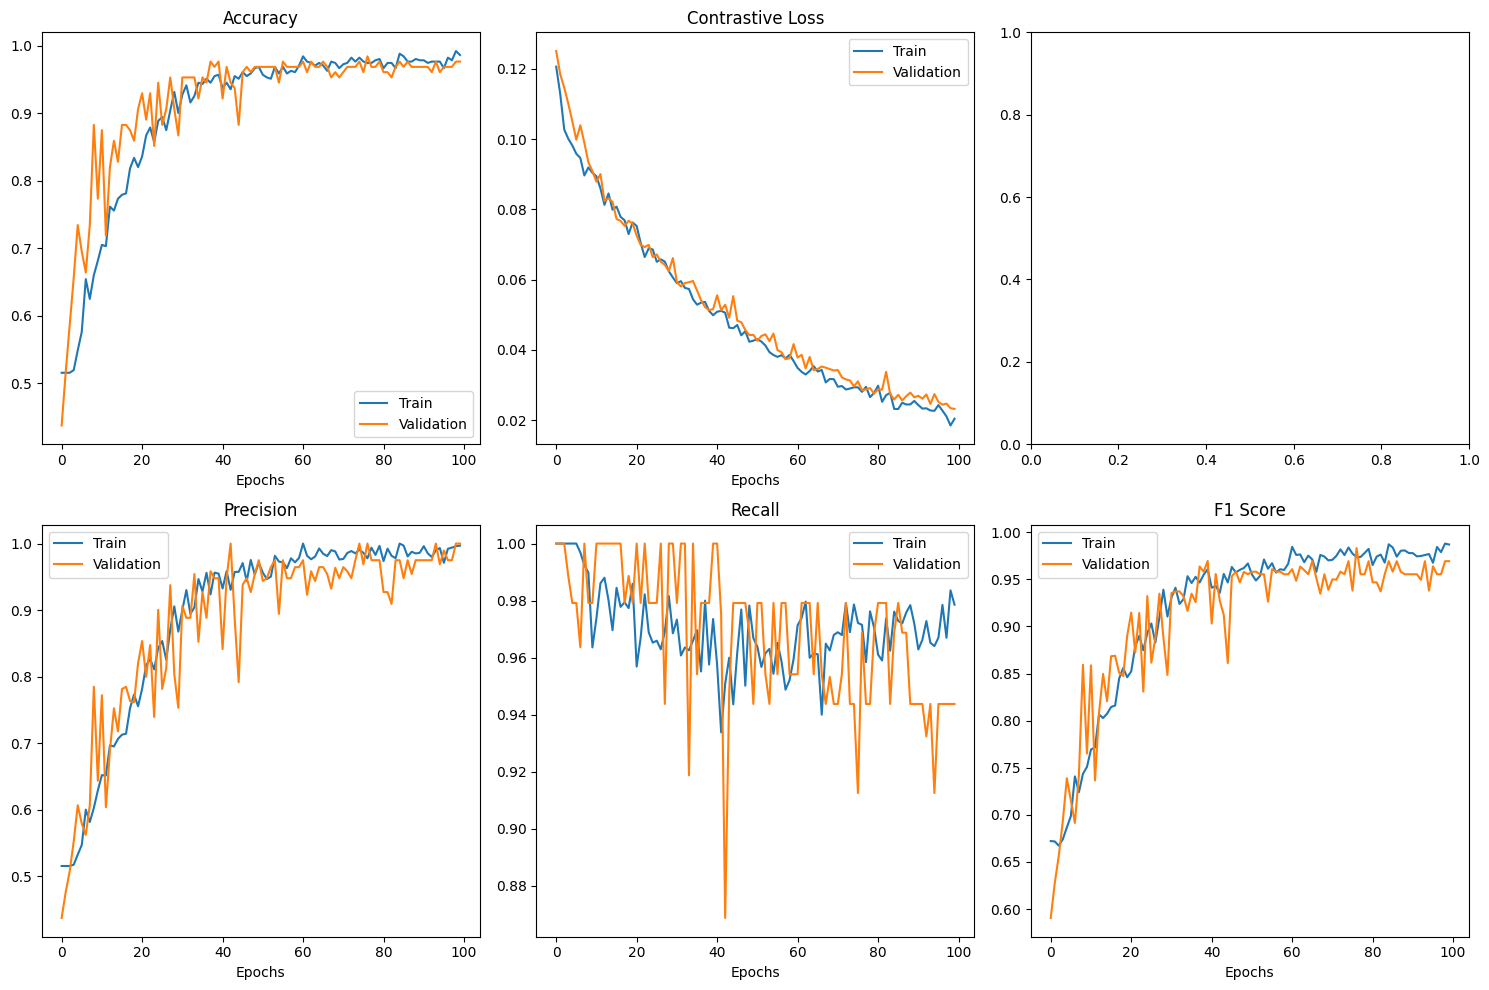

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].plot(history.history["accuracy"], label="Train")
axs[0, 0].plot(history.history["val_accuracy"], label="Validation")
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].legend()

axs[0, 1].plot(history.history["loss"], label="Train")
axs[0, 1].plot(history.history["val_loss"], label="Validation")
axs[0, 1].set_title("Contrastive Loss")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].legend()


axs[1, 0].plot(history.history["precision"], label="Train")
axs[1, 0].plot(history.history["val_precision"], label="Validation")
axs[1, 0].set_title("Precision")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].legend()

axs[1, 1].plot(history.history["recall"], label="Train")
axs[1, 1].plot(history.history["val_recall"], label="Validation")
axs[1, 1].set_title("Recall")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].legend()

axs[1, 2].plot(history.history["f1_score"], label="Train")
axs[1, 2].plot(history.history["val_f1_score"], label="Validation")
axs[1, 2].set_title("F1 Score")
axs[1, 2].set_xlabel("Epochs")
axs[1, 2].legend()

plt.tight_layout()
plt.show()